Starter EDA and ConvNet implementation using Keras. 

Inspiration for this notebook comes from this [Keras blog post](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html) and the [VGG ConvNet paper](https://arxiv.org/pdf/1409.1556.pdf). 


In [19]:
import os, cv2, random
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Input, Dropout, Flatten, MaxPooling2D, Dense, Activation,Conv2D
from keras.optimizers import RMSprop
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from keras.utils import np_utils

## Preparing the Data

This function resizes the images to 64x64 and samples 2000 images (8%) of the data to run efficiently as a Kaggle Kernel. I also separated cats and dogs for exploratory analysis. 

In [20]:
TRAIN_DIR = '../input/train/'
TEST_DIR = '../input/test/'

ROWS = 64
COLS = 64
CHANNELS = 3

train_images = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)] # use this for full dataset
train_dogs =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'dog' in i]
train_cats =   [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR) if 'cat' in i]

test_images =  [TEST_DIR+i for i in os.listdir(TEST_DIR)]


# slice datasets for memory efficiency on Kaggle Kernels, delete if using full dataset
#try to use more images this time
train_images = train_dogs[:2500] + train_cats[:2500]
random.shuffle(train_images)
#test_images =  test_images[:25]

def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)


def prep_data(images):
    count = len(images)
    data = np.ndarray((count, CHANNELS, ROWS, COLS), dtype=np.uint8)

    for i, image_file in enumerate(images):
        image = read_image(image_file)
        data[i] = image.T
        if i%250 == 0: print('Processed {} of {}'.format(i, count))
    
    return data



train = prep_data(train_images).transpose((0,2,3,1))
train_length=train.shape[0]
test = prep_data(test_images).transpose((0,2,3,1))
print("Train shape: {}".format(train.shape))
print("Test shape: {}".format(test.shape))


Processed 0 of 5000
Processed 250 of 5000
Processed 500 of 5000
Processed 750 of 5000
Processed 1000 of 5000
Processed 1250 of 5000
Processed 1500 of 5000
Processed 1750 of 5000
Processed 2000 of 5000
Processed 2250 of 5000
Processed 2500 of 5000
Processed 2750 of 5000
Processed 3000 of 5000
Processed 3250 of 5000
Processed 3500 of 5000
Processed 3750 of 5000
Processed 4000 of 5000
Processed 4250 of 5000
Processed 4500 of 5000
Processed 4750 of 5000
Processed 0 of 12500
Processed 250 of 12500
Processed 500 of 12500
Processed 750 of 12500
Processed 1000 of 12500
Processed 1250 of 12500
Processed 1500 of 12500
Processed 1750 of 12500
Processed 2000 of 12500
Processed 2250 of 12500
Processed 2500 of 12500
Processed 2750 of 12500
Processed 3000 of 12500
Processed 3250 of 12500
Processed 3500 of 12500
Processed 3750 of 12500
Processed 4000 of 12500
Processed 4250 of 12500
Processed 4500 of 12500
Processed 4750 of 12500
Processed 5000 of 12500
Processed 5250 of 12500
Processed 5500 of 12500


### Generating the Labels

We're dealing with a binary classification problem here - (1) dog (0) cat. The lables can be created by looping over the file names in the train directory. It's nice to see the training data is perfectly balanced. 

Text(0.5,1,'Cats and Dogs')

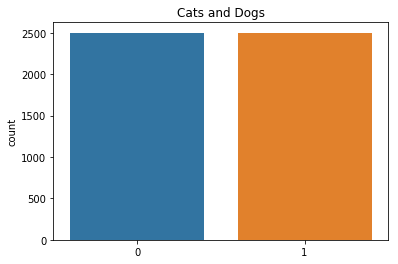

In [23]:
labels = []
for i in train_images:
    if 'dog' in i:
        labels.append(1)
    else:
        labels.append(0)

sns.countplot(labels)
plt.title('Cats and Dogs')

### Checking out Cats and Dogs
A quick side-by-side comparison of the animals.

In [5]:
#def show_cats_and_dogs(idx):
#    cat = read_image(train_cats[idx])
#    dog = read_image(train_dogs[idx])
#    pair = np.concatenate((cat, dog), axis=1)
#    plt.figure(figsize=(10,5))
#    plt.imshow(pair)
#    plt.show()
#    
#for idx in range(train_length,train_length-5,):
#    show_cats_and_dogs(idx)

### Your Average Cat and Dog Photo

Just for fun, the mean pixel values for cats and dogs. I can almost see a resemblance, a ghost, if you will...

In [ ]:
dog_avg = np.array([dog[0].T for i, dog in enumerate(train) if labels[i]==1]).mean(axis=0)
plt.imshow(dog_avg)
plt.title('Your Average Dog')

In [ ]:
cat_avg = np.array([cat[0].T for i, cat in enumerate(train) if labels[i]==0]).mean(axis=0)
plt.imshow(cat_avg)
plt.title('Your Average Cat')

## CatdogNet-16

A scaled down version of the VGG-16, with a few notable changes.

- Number of convolution filters cut in half, fully connected (dense) layers scaled down. 
- Optimizer changed to `RMSprop`. 
- Output layer activation set to `sigmoid` for binary crossentropy. 
- Some layers commented out for efficiency.

The full network takes about 80s per epoch on a GTX1070 (or 2hr+ on CPU) on the full dataset.  (This script only trains on 8% of the 25K images. )

In [27]:
optimizer = RMSprop(lr=1e-4)
objective = 'binary_crossentropy'


def catdog():
    
    model = Sequential()

    model.add(Conv2D(32, (3, 3),input_shape=(ROWS, COLS,3), activation='relu',padding='same'))
    model.add(Conv2D(32, (3, 3), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(64, (3, 3),activation='relu',padding='same'))
    model.add(Conv2D(64, (3, 3),activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu',padding='same'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
    model.add(Dropout(0.5))
    model.add(Conv2D(256, (3, 3), activation='relu',padding='same'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))

#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(Convolution2D(256, 3, 3, border_mode='same', activation='relu'))
#     model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))

    model.add(Dense(1))
    model.add(Activation('sigmoid'))

    model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])
    return model


model = catdog()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 64, 64, 32)        896       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 16, 16, 128)       73856     
__________

### Train and Predict

I'm using Keras's early stopping callback to end training when the validation loss stops improving, otherwise the model will overfit. I will also be tracking the loss history on each epoch to visualize the overfitting trend. 

Note: A slice of 1000 images was used to fit the model for CPU efficency. The model's perfrmance improves significantly when used on the entire dataset. 

In [28]:
nb_epoch = 10
batch_size = 10

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')        
        
#def run_catdog():
    
#    history = LossHistory()
#    model.fit(train, labels, batch_size=batch_size, nb_epoch=nb_epoch,
#              validation_split=0.25, verbose=0, shuffle=True, callbacks=[history, early_stopping])
    

#    predictions = model.predict(test, verbose=0)
#    return predictions, history

#predictions, history = run_catdog()

model.fit(train,
          labels,
          epochs=nb_epoch,
          batch_size=batch_size,
          validation_split=0.25)


Train on 3750 samples, validate on 1250 samples
Epoch 1/10
3000/3750 [=======================>......] - ETA: 28s - loss: 0.7592 - acc: 0.5037

KeyboardInterrupt: 

In [9]:
loss = history.losses
val_loss = history.val_losses

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('VGG-16 Loss Trend')
plt.plot(loss, 'blue', label='Training Loss')
plt.plot(val_loss, 'green', label='Validation Loss')
plt.xticks(range(0,nb_epoch)[0::2])
plt.legend()
plt.show()

## How'd We Do?

I'm pretty sure I can distinguish a cat from a dog 100% of the time, but how confident is the model?...

Tip: Run on the full dataset with a GPU for a LB logloss of ~0.4 and accuracy at approx 90%. 

In [ ]:
#for i in range(0,10):
#    if predictions[i, 0] >= 0.5: 
#        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
#    else: 
#        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
#        
#    plt.imshow(test[i])
#    plt.show()

In [16]:
predictions = model.predict(test, batch_size=16, verbose=1)

In [17]:
from os.path import join, basename

In [21]:
with open('submission.csv','w') as f:
    f.write('id,label\n')
    for index in range(len(test_images)):
        img_id =basename(test_images[index]).split(".")[0]
        prob = (predictions[index,0])
        #print("index: {}, img_id: {}, prob:{}".format(index,img_id, prob))
        f.write("{},{}\n".format(img_id, prob))